In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm #to create progress bar
import cv2 
import os

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [22]:
#from numba import jit, cuda

### Constants

In [3]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # 3 for Colored Images and 1 for Grayscale Images
BATCH_SIZE=32
EPOCHS= 100

if FAST_RUN:
    EPOCHS= 5 

In [4]:
from os import listdir
from os.path import isfile, join
mypath = 'F:\\akash\\CS539_project\\birds\\birds\\20\\test'


In [5]:
#class_names = ['001.Black_footed_Albatross',"002.Laysan_Albatross","003.Sooty_Albatross","004.Groove_billed_Ani","005.Crested_Auklet","006.Least_Auklet","007.Parakeet_Auklet","008.Rhinoceros_Auklet","009.Brewer_Blackbird","010.Red_winged_Blackbird","011.Rusty_Blackbird","012.Yellow_headed_Blackbird","013.Bobolink","014.Indigo_Bunting","015.Lazuli_Bunting","016.Painted_Bunting","017.Cardinal","018.Spotted_Catbird","019.Gray_Catbird","020.Yellow_breasted_Chat"]
class_names = os.listdir('F:\\akash\\CS539_project\\birds\\birds\\20\\test')
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

class_names_label

{'001.Black_footed_Albatross': 0,
 '002.Common_Yellowthroat': 1,
 '003.Carolina_Wren': 2,
 '004.Groove_billed_Ani': 3,
 '005.Crested_Auklet': 4,
 '006.Northern_Waterthrush': 5,
 '007.Wilson_Warbler': 6,
 '008.Yellow_throated_Vireo': 7,
 '009.Brewer_Blackbird': 8,
 '010.Brown_Thrasher': 9,
 '011.Common_Tern': 10,
 '012.Yellow_headed_Blackbird': 11,
 '013.Bobolink': 12,
 '014.Indigo_Bunting': 13,
 '015.White_throated_Sparrow': 14,
 '016.Painted_Bunting': 15,
 '017.Cardinal': 16,
 '018.Spotted_Catbird': 17,
 '019.Summer_Tanager': 18,
 '020.Yellow_breasted_Chat': 19}

### Load Data

In [6]:
def load_data():

    datasets = ['F:\\akash\\CS539_project\\birds\\birds\\20\\train', 'F:\\akash\\CS539_project\\birds\\birds\\20\\test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:

        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)
                
                if image is None: # To account for broken images
                    continue
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)   

        output.append((images, labels))
    

    return output

In [7]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading F:\akash\CS539_project\birds\birds\20\train


100%|██████████| 43/43 [00:00<00:00, 169.92it/s]


Loading F:\akash\CS539_project\birds\birds\20\test


100%|██████████| 16/16 [00:00<00:00, 179.74it/s]


### Explore Data

In [8]:
print(train_labels.shape[0])
print(test_labels.shape[0])

807
349


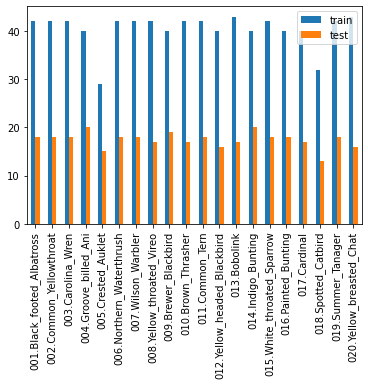

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Plot Sample Image

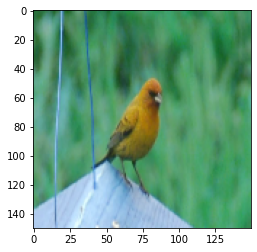

In [10]:
plt.imshow(random.choice(train_images))

In [11]:
train_labels=to_categorical(train_labels,20)   ## change the no 5 to whatever your number of classes
test_labels=to_categorical(test_labels,20)     ### change the no 5 to whatever your number of classes

In [12]:
train_images.shape

(807, 150, 150, 3)

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
#train_images = train_images.reshape(-1,IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)
#test_images = test_images.reshape(-1,IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)

### Model Training

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(2000, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(20, activation='softmax')) # 5 because we have 5 classes

model.compile(loss='binary_crossentropy', optimizer="rmsprop",metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [201]:
##import tensorflow as tf
#tf.keras.applications.VGG16(
#    include_top=True,
#    weights="imagenet",
#    input_tensor=None,
#    input_shape=None,
#    pooling=None,
#    classes=1000,
#    classifier_activation="softmax",
#)

553467904/553467096 [==============================] - 10s 0us/step


In [213]:
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

## this could also be the output a different Keras model or layer
#input_tensor = Input(shape=(224, 224, 3))

#model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

96116736/96112376 [==============================] - 2s 0us/step


In [14]:
model.compile(loss='binary_crossentropy', optimizer="rmsprop",metrics=['accuracy'])

##### Early Stopping



In [15]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction



In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

#### Data Augmentation to Prevent Overfitting

#### Training Generator

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator= train_datagen.flow(
    train_images, 
    train_labels,
    batch_size= BATCH_SIZE)

#### Validation Generator



In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator= test_datagen.flow(test_images, test_labels,batch_size= BATCH_SIZE)

### Check Sample Image after augmentation

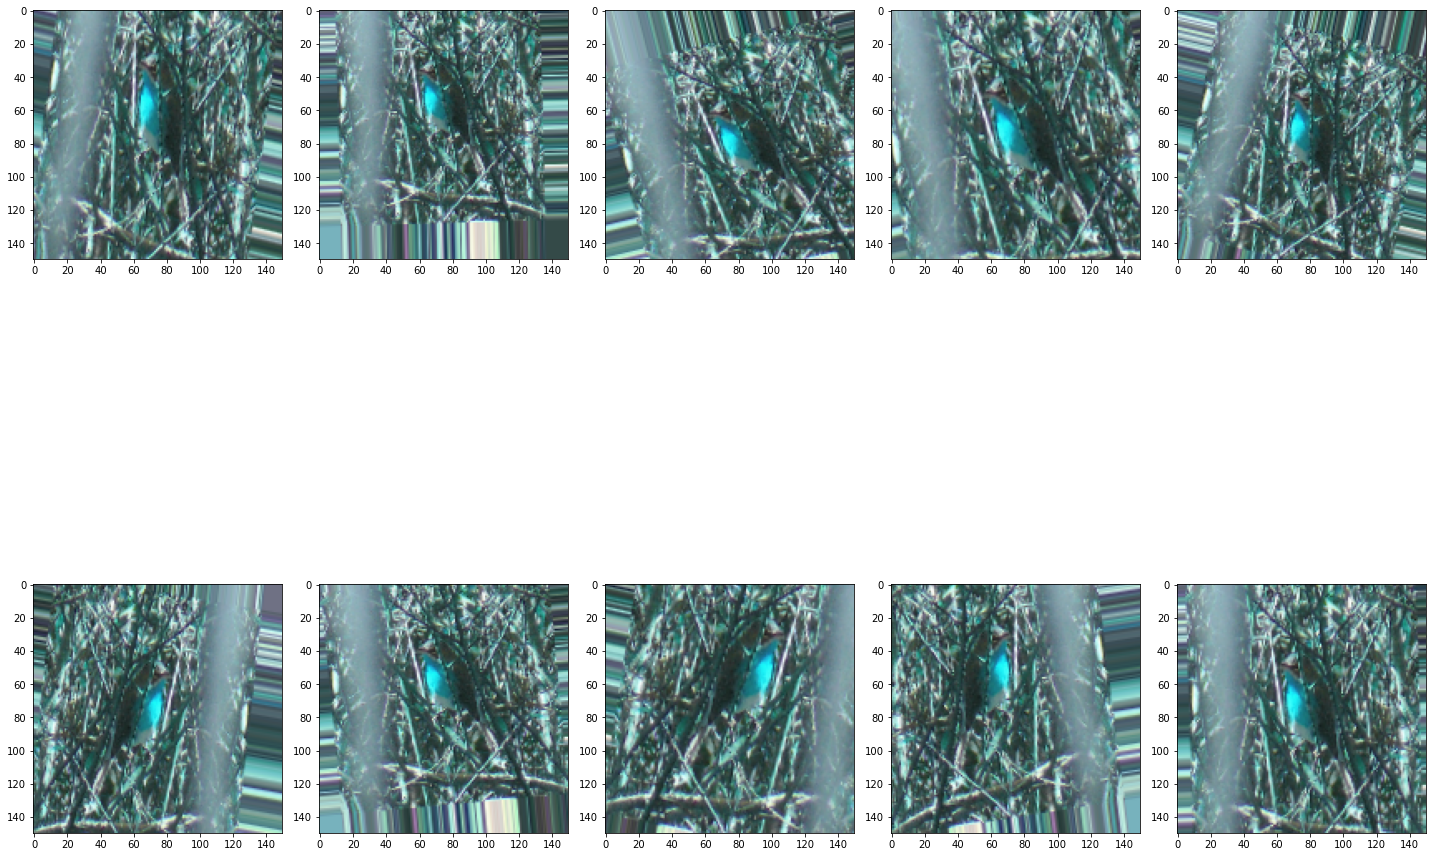

In [22]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

augmented_images = [train_generator[0][0][0] for i in range(10)]
plotImages(augmented_images)

### Fit Model



In [23]:
  
# function optimized to run on gpu 
#@jit(target ="gpu")

#%%time
hist = model.fit(train_generator,
    epochs=EPOCHS,
    validation_data= test_generator,
    steps_per_epoch=train_images.shape[0]/BATCH_SIZE,
    #callbacks=callbacks 
) 

Epoch 1/100
25/25 [==============================] - 8s 262ms/step - loss: 0.2722 - accuracy: 0.0397 - val_loss: 0.2241 - val_accuracy: 0.0688
Epoch 2/100
25/25 [==============================] - 7s 280ms/step - loss: 0.2175 - accuracy: 0.0768 - val_loss: 0.1979 - val_accuracy: 0.1060
Epoch 3/100
25/25 [==============================] - 7s 278ms/step - loss: 0.1911 - accuracy: 0.1549 - val_loss: 0.1894 - val_accuracy: 0.1977
Epoch 4/100
25/25 [==============================] - 7s 291ms/step - loss: 0.1794 - accuracy: 0.1846 - val_loss: 0.1899 - val_accuracy: 0.1719
Epoch 5/100
25/25 [==============================] - 7s 273ms/step - loss: 0.1676 - accuracy: 0.2416 - val_loss: 0.1600 - val_accuracy: 0.2464
Epoch 6/100
25/25 [==============================] - 7s 274ms/step - loss: 0.1560 - accuracy: 0.3123 - val_loss: 0.1494 - val_accuracy: 0.3438
Epoch 7/100
25/25 [==============================] - 7s 277ms/step - loss: 0.1523 - accuracy: 0.3172 - val_loss: 0.1466 - val_accuracy: 0.3266

### Saving the model

In [170]:
model.save('keras_20.h5')

#Load Model
#model3= keras.models.load_model("../input/model-v3/keras_30.h5")

### Model Evaluation

In [24]:
test_loss = model.evaluate(test_images, test_labels)

11/11 [==============================] - 1s 67ms/step - loss: 43.3943 - accuracy: 0.5587


##### Plotting Loss and Accuracy graphs for Training and Validation datasets

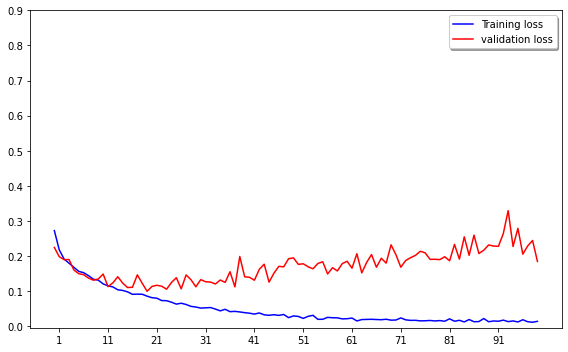

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 10))
ax1.set_yticks(np.arange(0, 1, 0.1))




legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

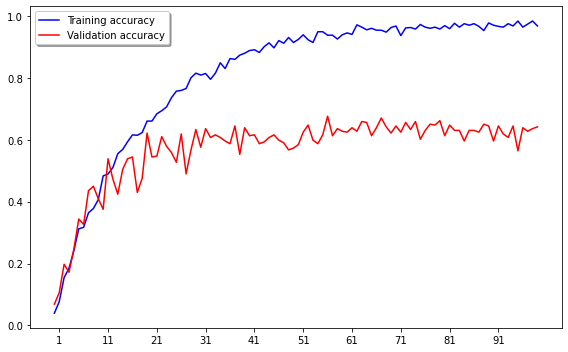

In [26]:
fig, ax2 = plt.subplots(1, 1, figsize=(8, 5))

ax2.plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 10))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Making Predictions

In [29]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

11/11 [==============================] - 1s 66ms/step


In [30]:
#Reverse conversion from to_categorical
test_labels_vector = np.argmax(test_labels, axis = 1)

### Confusion Matrix

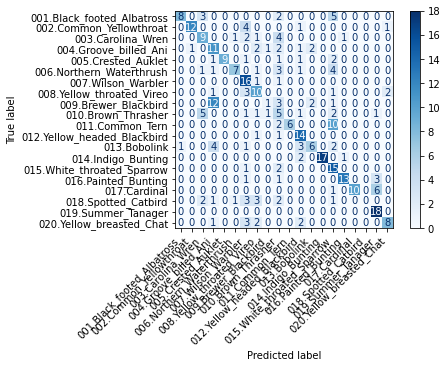

In [31]:
cm = confusion_matrix(test_labels_vector, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')##
plt.figsize=(12, 8)
plt.show()

### Classification Report

In [32]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_vector, pred_labels, target_names = class_names))

                             precision    recall  f1-score   support

 001.Black_footed_Albatross       0.89      0.44      0.59        18
    002.Common_Yellowthroat       0.92      0.67      0.77        18
          003.Carolina_Wren       0.45      0.50      0.47        18
      004.Groove_billed_Ani       0.34      0.55      0.42        20
         005.Crested_Auklet       1.00      0.60      0.75        15
   006.Northern_Waterthrush       0.78      0.39      0.52        18
         007.Wilson_Warbler       0.44      0.89      0.59        18
  008.Yellow_throated_Vireo       0.45      0.59      0.51        17
       009.Brewer_Blackbird       0.33      0.05      0.09        19
         010.Brown_Thrasher       0.17      0.29      0.22        17
            011.Common_Tern       1.00      0.33      0.50        18
012.Yellow_headed_Blackbird       0.54      0.88      0.67        16
               013.Bobolink       0.60      0.35      0.44        17
         014.Indigo_Bunting      

C:\Users\aanand37\.conda\envs\cnn_birds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aanand37\.conda\envs\cnn_birds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aanand37\.conda\envs\cnn_birds\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Misclassified Images


In [184]:
def classification_evaluation(classification, predicted_labels, test_labels, test_images):
    if classification== "correct":
        indices_list = np.where(predicted_labels == test_labels)[0]
    else:
        indices_list = np.where(predicted_labels!= test_labels)[0]
    test_images_filtered= [test_images[i] for i in indices_list]
    images_labels_original= [test_labels[i] for i in indices_list]
    images_labels_predicted= [pred_labels[i] for i in indices_list]
    print(f"{len(test_images_filtered)} images were classified {classification.upper()} out of a total of {len(test_images)} in the Test dataset")

    unique, counts = np.unique(images_labels_original, return_counts=True)
    for i in range(0,len(unique)):
        print(f"for category {unique[i]} the number of {classification.upper()} classified images were: {counts[i]}")
        
    # Plot some of the misclassified images
    print("\n\n")
    fig,ax=plt.subplots(5,2)
    fig.suptitle(f"Sample of {classification.upper()} Classified Images", fontsize=20)
    fig.set_size_inches(15,15)
    for i in range(5):
        for j in range (2):
            l=random.randint(0,len(test_images_filtered))
            ax[i,j].imshow(test_images_filtered[l])
            ax[i,j].set_title("Predicted: "+str(images_labels_predicted[l])+"\n"+"Actual: "+str(images_labels_original[l]))
    plt.tight_layout()

155 images were classified INCORRECT out of a total of 349 in the Test dataset
for category 0 the number of INCORRECT classified images were: 12
for category 1 the number of INCORRECT classified images were: 4
for category 2 the number of INCORRECT classified images were: 13
for category 3 the number of INCORRECT classified images were: 13
for category 4 the number of INCORRECT classified images were: 7
for category 5 the number of INCORRECT classified images were: 14
for category 6 the number of INCORRECT classified images were: 5
for category 7 the number of INCORRECT classified images were: 10
for category 8 the number of INCORRECT classified images were: 14
for category 9 the number of INCORRECT classified images were: 9
for category 10 the number of INCORRECT classified images were: 7
for category 11 the number of INCORRECT classified images were: 3
for category 12 the number of INCORRECT classified images were: 6
for category 13 the number of INCORRECT classified images were: 6
f

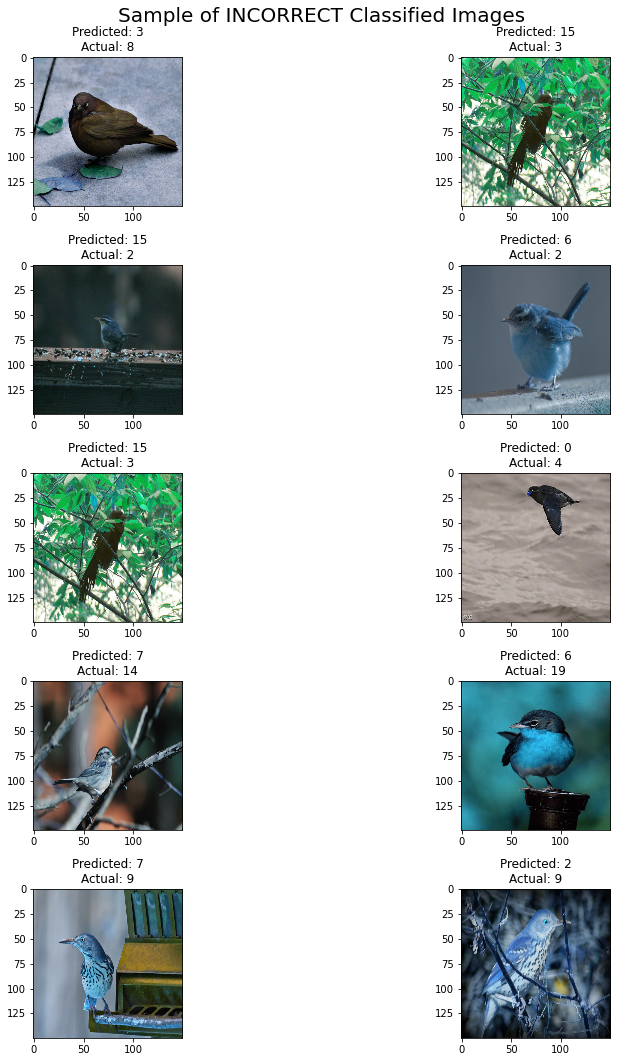

In [185]:
classification_evaluation("incorrect", pred_labels, test_labels_vector, test_images)

### Correctly Classified Images

Let us also look at some of the Images which the algorithm classified correctly :)

119 images were classified CORRECT out of a total of 340 in the Test dataset
for category 0 the number of CORRECT classified images were: 10
for category 2 the number of CORRECT classified images were: 1
for category 3 the number of CORRECT classified images were: 2
for category 4 the number of CORRECT classified images were: 5
for category 6 the number of CORRECT classified images were: 4
for category 7 the number of CORRECT classified images were: 3
for category 9 the number of CORRECT classified images were: 16
for category 10 the number of CORRECT classified images were: 1
for category 11 the number of CORRECT classified images were: 16
for category 12 the number of CORRECT classified images were: 2
for category 13 the number of CORRECT classified images were: 14
for category 14 the number of CORRECT classified images were: 2
for category 15 the number of CORRECT classified images were: 17
for category 16 the number of CORRECT classified images were: 15
for category 17 the number o

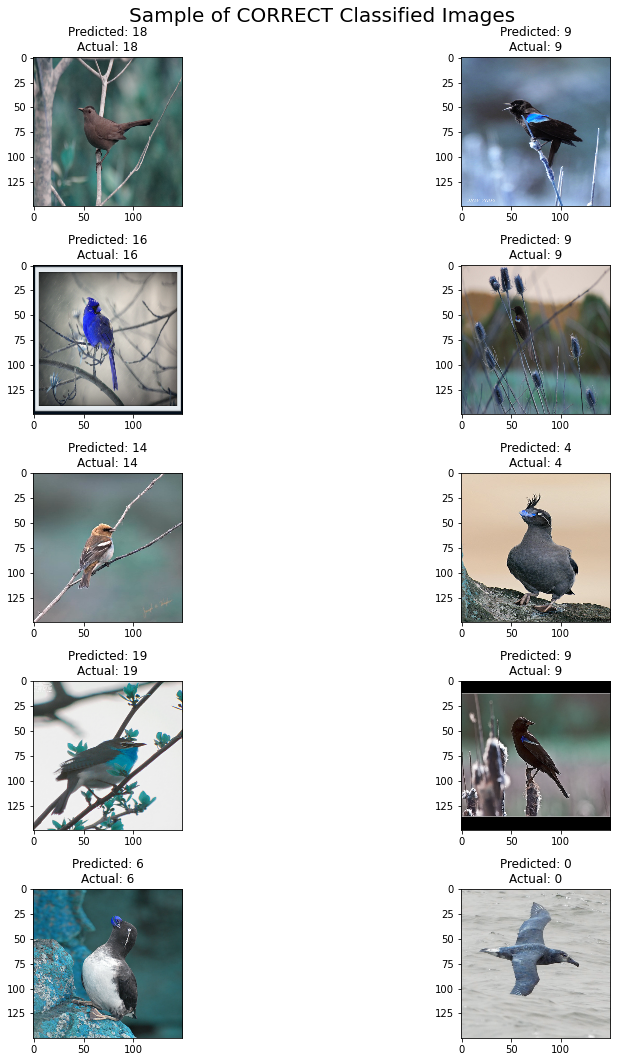

In [80]:
classification_evaluation("correct", pred_labels, test_labels_vector, test_images)